# Importing Libraries

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict


from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

# Loading data

In [9]:
from hitters_data import *

In [10]:
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

In [11]:
params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "warm_start":True,
    "oob_score":True,
    "random_state": 42,
}

In [12]:
reg =RandomForestRegressor(**params)

reg.fit(X_train, y_train)

C:\Users\hp\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestRegressor(max_depth=4, min_samples_split=5, n_estimators=500,
                      oob_score=True, random_state=42, warm_start=True)

In [13]:
RandomForestRegressor(max_depth=4, min_samples_split=5, n_estimators=500,
                      oob_score=True, random_state=42, warm_start=True)


RandomForestRegressor(max_depth=4, min_samples_split=5, n_estimators=500,
                      oob_score=True, random_state=42, warm_start=True)

In [14]:
y_pred = reg.predict(X_test)


In [15]:
mean_squared_error(y_test, y_pred, squared=False)

296.37036964432764

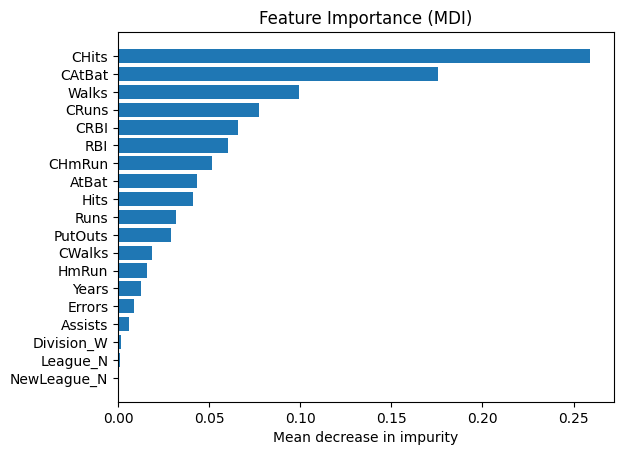

In [16]:
feature_importance = reg.feature_importances_

# sort features according to importance
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0])

# plot feature importances
plt.barh(pos, feature_importance[sorted_idx], align="center")

plt.yticks(pos, np.array(feature_names)[sorted_idx])
plt.title("Feature Importance (MDI)")
plt.xlabel("Mean decrease in impurity");
